In [ ]:
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, StandardScaler

file_q = h5py.File("datasets/jetnet/q.hdf5", 'r')
file_g = h5py.File("datasets/jetnet/g.hdf5", 'r')
file_w = h5py.File("datasets/jetnet/w.hdf5", 'r')
file_z = h5py.File("datasets/jetnet/z.hdf5", 'r')
file_t = h5py.File("datasets/jetnet/t.hdf5", 'r')
x_q = file_q['particle_features'][:]
x_g = file_g['particle_features'][:]
x_w = file_w['particle_features'][:]
x_z = file_z['particle_features'][:]
x_t = file_t['particle_features'][:]

y_q = np.tile([1,0,0,0,0], (x_q.shape[0], 1))
y_g = np.tile([0,1,0,0,0], (x_g.shape[0], 1))
y_w = np.tile([0,0,1,0,0], (x_w.shape[0], 1))
y_z = np.tile([0,0,0,1,0], (x_z.shape[0], 1))
y_t = np.tile([0,0,0,0,1], (x_t.shape[0], 1))

x_all = np.concatenate([x_q, x_g, x_w, x_z, x_t], axis=0)
y_all = np.concatenate([y_q, y_g, y_w, y_z, y_t], axis=0)

indices = np.arange(x_all.shape[0])
np.random.seed(42)
np.random.shuffle(indices)

x_all = x_all[indices]
y_all = y_all[indices]

n_train = 150000
n_val = 1000
#n_test = x_all.shape[0] - n_train - n_val
n_test = 200000

x_train = x_all[:n_train]
y_train = y_all[:n_train]

x_val = x_all[n_train:n_train + n_val]
y_val = y_all[n_train:n_train + n_val]

x_test = x_all[n_train + n_val:]
y_test = y_all[n_train + n_val:]

del x_all, y_all

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (150000, 30, 4)
y_train shape: (150000, 5)
x_val shape: (10000, 30, 4)
y_val shape: (10000, 5)
x_test shape: (720000, 30, 4)
y_test shape: (720000, 5)


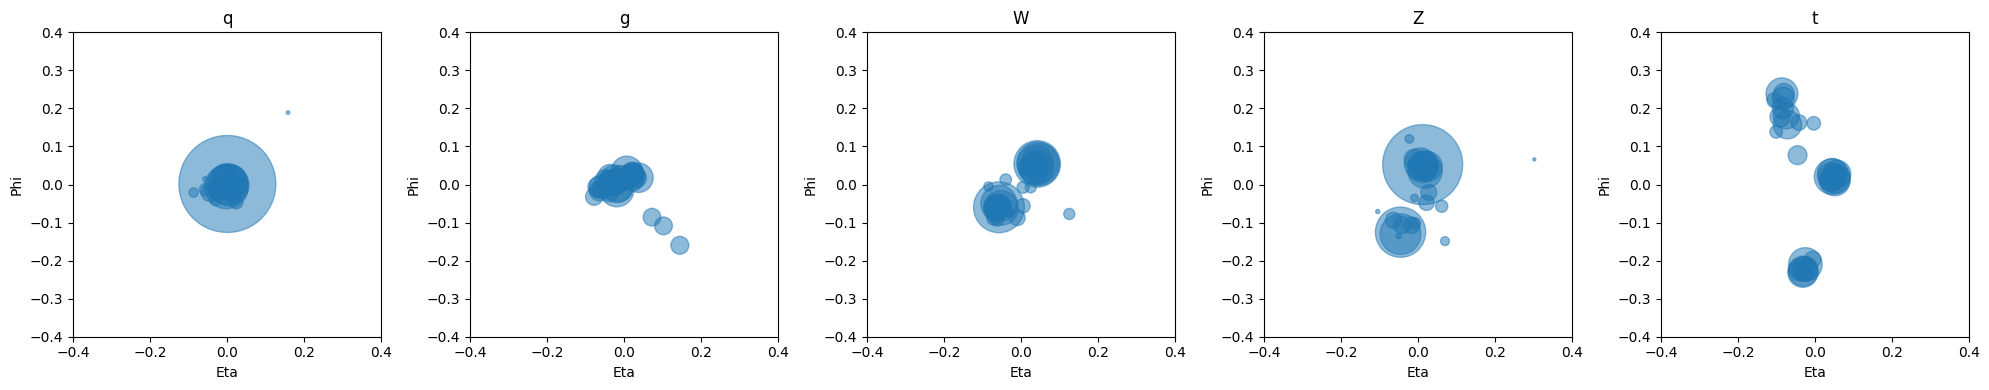

In [2]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
class_names = ['q', 'g', 'W', 'Z', 't']

for i, class_name in enumerate(class_names):
    class_idx = np.where(y_train.argmax(axis=1)==i)[0][0]
    jet = x_train[class_idx]
    eta = jet[:,0]
    phi = jet[:,1]
    pt = jet[:,2]
    mask = jet[:,3]
    
    eta = eta[mask==1]
    phi = phi[mask==1]
    pt = pt[mask==1]

    size = pt*10000

    axs[i].scatter(eta, phi, color='C0', s=size, alpha=0.5)
    axs[i].set_xlabel("Eta")
    axs[i].set_ylabel("Phi")
    axs[i].set_title(class_name)
    axs[i].set_xlim(-0.4, 0.4)
    axs[i].set_ylim(-0.4, 0.4)

plt.tight_layout()
plt.show()

In [3]:
# --- augmentations
RNG = np.random.default_rng(42)

def rotate_eta_phi(jet):
    theta = RNG.uniform(-np.pi, np.pi)
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    eta, phi, pt, valid = jet.T
    eta_r = cos_t*eta - sin_t*phi
    phi_r = sin_t*eta + cos_t*phi
    jet_r = np.vstack([eta_r, phi_r, pt, valid]).T
    return jet_r

def gaussian_smear_eta_phi(jet):
    eta, phi, pt, valid = jet.T
    sigma = 3e-4 / np.clip(pt, 1e-6, None) # 1e-4 = (QCD_scale 100 MeV) / (1 TeV); pt is particle pt / jet pt
    eta_s = eta + RNG.normal(0., sigma)
    phi_s = phi + RNG.normal(0., sigma)
    phi_s = np.where(phi_s > np.pi, phi_s - 2*np.pi,
            np.where(phi_s <= -np.pi, phi_s + 2*np.pi, phi_s))
    jet_s = np.vstack([eta_s, phi_s, pt, valid]).T
    return jet_s

def split_particles(jet):
    eta, phi, pt, valid = jet.T
    valid_idx = np.where(valid==1)[0]
    n_valid = valid_idx.size
    n_empty = 30 - n_valid
    if n_empty==0:
        return jet.copy().astype(np.float32)

    n_split  = min(n_empty, n_valid)
    to_split = RNG.choice(valid_idx, n_split, replace=False)

    extra = []
    for idx in to_split:
        a = RNG.uniform(0.3, 0.7)
        pt1 = a*pt[idx]
        pt2 = (1-a)*pt[idx]
        pt[idx] = pt1
        extra.append([eta[idx], phi[idx], pt2, 1.])

    jet_new = np.concatenate([jet, np.array(extra, dtype=np.float32)], axis=0)

    if jet_new.shape[0]<30:
        pad = np.zeros((30 - jet_new.shape[0], 4), dtype=np.float32)
        jet_new = np.concatenate([jet_new, pad], axis=0)
    return jet_new[:30].astype(np.float32)

def augment_jet(jet):
    jet = rotate_eta_phi(jet)
    jet = gaussian_smear_eta_phi(jet)
    jet = split_particles(jet)
    return jet.astype(np.float32) 

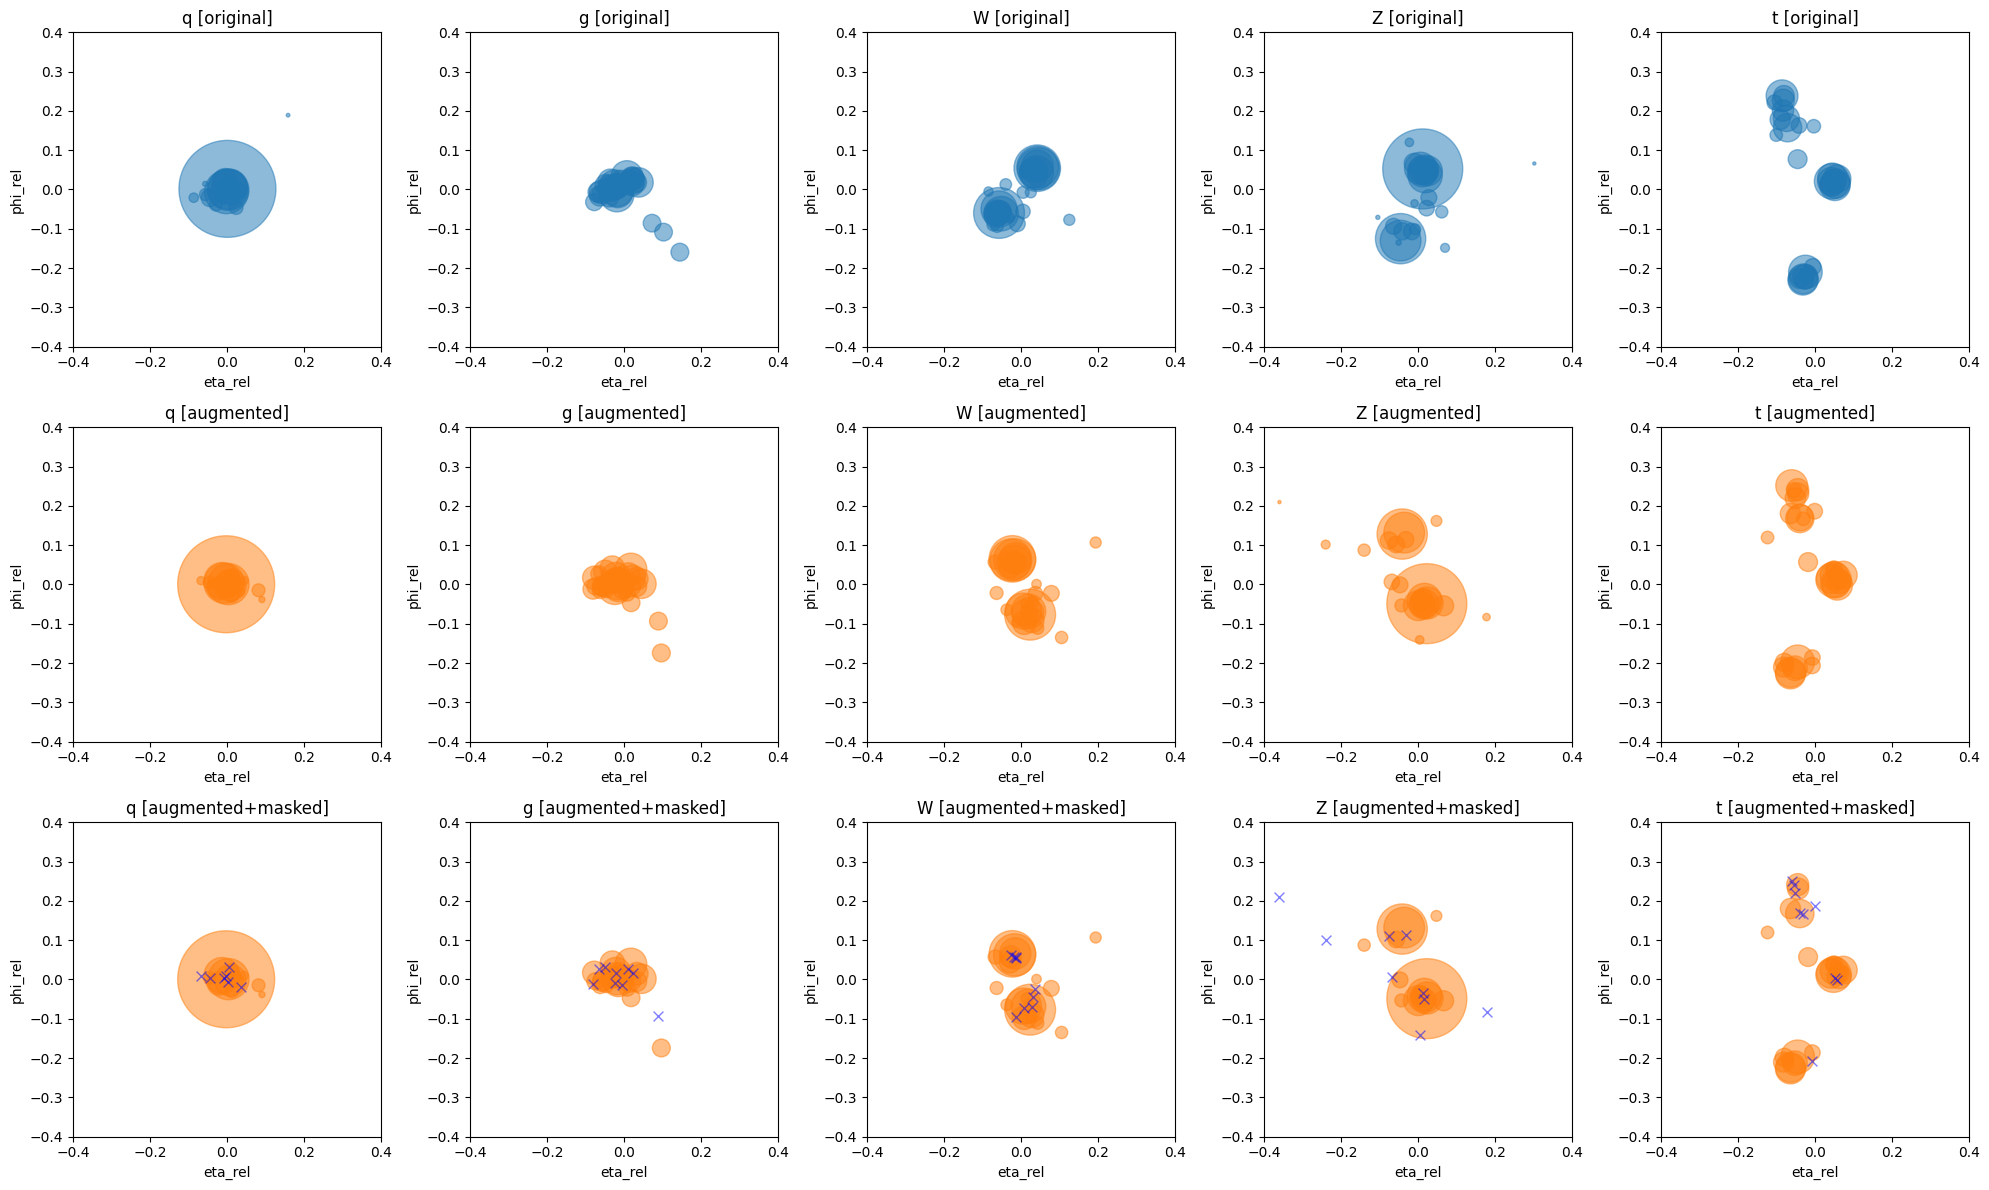

In [4]:
RNG = np.random.default_rng(42)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
class_names = ['q', 'g', 'W', 'Z', 't']
mask_ratio = 0.3

for col, cname in enumerate(class_names):
    idx = np.where(y_train.argmax(axis=1)==col)[0][0]
    jet_orig = x_train[idx]

    # original
    eta, phi, pt, valid = jet_orig.T
    axes[0, col].scatter(eta[valid==1], phi[valid==1], color='C0', s=pt[valid==1]*1e4, alpha=0.5)
    axes[0, col].set_title(f"{cname} [original]")

    # augmented
    jet_aug = augment_jet(jet_orig)
    eta, phi, pt, valid = jet_aug.T
    axes[1, col].scatter(eta[valid==1], phi[valid==1], color='C1', s=pt[valid==1]*1e4, alpha=0.5)
    axes[1, col].set_title(f"{cname} [augmented]")

    # augmented + masks
    eta, phi, pt, valid = jet_aug.T
    valid_idx = np.where(valid==1)[0]
    n_valid = valid_idx.size
    n_mask = max(1, int(np.ceil(mask_ratio * n_valid)))
    mask_idx = RNG.choice(valid_idx, n_mask, replace=False)

    mask_bool = np.zeros_like(pt, dtype=bool)
    mask_bool[mask_idx] = True

    pt_masked = pt.copy()
    pt_masked[mask_bool] = 0

    unmasked = (valid==1) & (~mask_bool)
    masked = (valid==1) & mask_bool

    axes[2, col].scatter(eta[unmasked], phi[unmasked], color='C1', s=pt_masked[unmasked]*1e4, alpha=0.5)
    axes[2, col].scatter(eta[masked], phi[masked], marker='x', color='blue', s=50, linewidths=1, alpha=0.5)
    axes[2, col].set_title(f"{cname} [augmented+masked]")

    for row in range(3):
        axes[row, col].set_xlim(-0.4, 0.4)
        axes[row, col].set_ylim(-0.4, 0.4)
        axes[row, col].set_xlabel("eta_rel")
        axes[row, col].set_ylabel("phi_rel")

plt.tight_layout()
plt.show()

## build ibot model

In [5]:
class AddClsToken(Layer):
    # add [CLS] token: (batch, n_tokens, d_model) -> (batch, n_tokens+1, d_model)
    def __init__(self, d_model, **kw):
        super().__init__(**kw)
        self.cls = self.add_weight("cls_token", shape=(1, 1, d_model), initializer="zeros", trainable=True)

    def call(self, x):
        # tile along the batch dimension
        cls_token = tf.tile(self.cls, [tf.shape(x)[0], 1, 1])
        return tf.concat([cls_token, x], axis=1)

class TransformerBlock(Layer):
    def __init__(self, d_model, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(n_heads, d_model//n_heads)
        self.ln1 = LayerNormalization(epsilon=1e-6)
        self.ln2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([Dense(4*d_model, activation='relu'), Dense(d_model)])
        self.drop1 = Dropout(0.2)
        self.drop2 = Dropout(0.2)

    def call(self, x):
        attn_out = self.mha(x, x)
        attn_out = self.ln1(x + self.drop1(attn_out))

        ffn_out = self.ffn(attn_out)
        ffn_out = self.ln2(attn_out + self.drop2(ffn_out))
        return ffn_out

def build_backbone(d_model, n_heads, n_layers, name="backbone"):
    x_in = keras.Input((30, 4), name='particles_in') 

    # linear projection for token embedding
    x = Dense(d_model, name="token_embedding")(x_in)

    # prepend [CLS] token
    x = AddClsToken(d_model, name="prepend_cls")(x)

    # transformer blocks
    for i in range(n_layers):
        x = TransformerBlock(d_model, n_heads, name=f"block_{i}")(x)

    # split CLS and patch (particle) outputs
    cls_out = x[:, 0]
    particle_out = x[:, 1:]
    return keras.Model(x_in, [cls_out, particle_out], name=name)

def build_proj_head(d_in, d_proj, name):
    head = keras.Sequential([
        Dense(d_proj, activation='relu'),
        Dense(d_proj),
        Lambda(lambda t: tf.math.l2_normalize(t, -1))
    ], name=name)
    head.build((None, None, d_in))
    return head

d_model=64
n_heads=3
n_layers=3
d_proj=64

student = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)
teacher = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)

proj_head_s = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_student")
proj_head_t = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_teacher")

teacher.set_weights(student.get_weights())
proj_head_t.set_weights(proj_head_s.get_weights())
teacher.trainable = False
proj_head_t.trainable = False

print(student.summary())
print(proj_head_s.summary())

Model: "backbone"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 particles_in (InputLayer)   [(None, 30, 4)]              0         []                            
                                                                                                  
 token_embedding (Dense)     (None, 30, 64)               320       ['particles_in[0][0]']        
                                                                                                  
 prepend_cls (AddClsToken)   (None, 31, 64)               64        ['token_embedding[0][0]']     
                                                                                                  
 block_0 (TransformerBlock)  (None, 31, 64)               49725     ['prepend_cls[0][0]']         
                                                                                           

In [6]:
# --- wrappers for tf.data
def tf_augment_batch(jets):
    def aug_(j):
        out = tf.numpy_function(augment_jet, [j], tf.float32)
        out.set_shape((30, 4))
        return out
    return tf.map_fn(aug_, jets, fn_output_signature=tf.TensorSpec((30,4), tf.float32))

def tf_mask_batch(jets, pT_mask_token, mask_ratio_ibot):
    def mask_(jet):
        eta, phi, pt, valid = tf.unstack(jet, axis=1)
        valid_idx = tf.where(tf.equal(valid, 1.))[:,0]
        n_valid = tf.size(valid_idx)
        n_mask = tf.maximum(1, tf.cast(tf.math.ceil(mask_ratio_ibot * tf.cast(n_valid, tf.float32)), tf.int32))
        mask_idx = tf.random.shuffle(valid_idx)[:n_mask]

        mask_bool = tf.scatter_nd(tf.expand_dims(mask_idx,1), tf.ones_like(mask_idx, tf.bool), [30])
        pt_masked = tf.where(mask_bool, pT_mask_token * tf.ones_like(pt), pt)
        jet_out = tf.stack([eta, phi, pt_masked, valid], axis=1)
        return jet_out, mask_bool

    jets_masked, masks = tf.map_fn(mask_, jets, fn_output_signature=(tf.TensorSpec((30,4), tf.float32), tf.TensorSpec((30,), tf.bool)))
    return jets_masked, masks

# --- centering for teacher logits
def update_center(tok_cls, tok_patch, center_cls, center_patch, center_beta):
    center_cls.assign(center_beta * center_cls + (1 - center_beta) * tf.reduce_mean(tok_cls, axis=0))
    center_patch.assign(center_beta * center_patch + (1 - center_beta) * tf.reduce_mean(tok_patch, axis=[0, 1]))

# --- loss def
def softmax_temp(x, t):
    return tf.nn.softmax(x/t, axis=-1)

def ce_teacher_student(t_logits, s_logits, temp_t=0.04, temp_s=0.1):
    p_t = tf.stop_gradient(softmax_temp(t_logits, temp_t))
    log_p_s = tf.nn.log_softmax(s_logits / temp_s, axis=-1)
    cross_entropy = -tf.reduce_mean(tf.reduce_sum(p_t * log_p_s, axis=-1))
    return cross_entropy

def ibot_loss(cls_s, cls_t, patch_s, patch_t, mask_bool, center_cls, center_patch):
    # CLS
    loss_cls = ce_teacher_student(cls_t - center_cls, cls_s)

    # masked tokens
    float_mask = tf.cast(mask_bool, tf.float32)[..., None]
    patch_s = patch_s * float_mask
    patch_t = (patch_t - center_patch) * float_mask

    # flatten everything
    patch_s_flat = tf.reshape(patch_s, [-1, d_proj])
    patch_t_flat = tf.reshape(patch_t, [-1, d_proj])
    bool_flat  = tf.reshape(mask_bool, [-1])

    # keep only masked positions
    patch_s_sel = tf.boolean_mask(patch_s_flat, bool_flat)
    patch_t_sel = tf.boolean_mask(patch_t_flat, bool_flat)

    loss_tok = ce_teacher_student(patch_t_sel, patch_s_sel)
    return loss_cls + loss_tok, loss_cls, loss_tok

In [7]:
def train_ibot(x_train, epochs, batch_size, optimizer, ema_tau, student, teacher, proj_head_s, proj_head_t, mask_ratio_ibot, pT_mask_token, center_cls, center_patch, center_beta, temp_t, temp_s):
    def ema_update(ema_tau=ema_tau):
        for s, t in zip(student.trainable_variables, teacher.variables):
            t.assign(ema_tau*t + (1-ema_tau)*s)
        for s, t in zip(proj_head_s.trainable_variables, proj_head_t.variables):
            t.assign(ema_tau*t + (1-ema_tau)*s)

    @tf.function
    def train_step(ds_jets, optimizer, student, teacher, proj_head_s, proj_head_t, pT_mask_token):
        # two augmented views u, v
        jet_u = tf_augment_batch(ds_jets)
        jet_v = tf_augment_batch(ds_jets)

        with tf.GradientTape() as tape:
            jet_u_masked, mask_u = tf_mask_batch(jet_u, pT_mask_token, mask_ratio_ibot=mask_ratio_ibot)
            jet_v_masked, mask_v = tf_mask_batch(jet_v, pT_mask_token, mask_ratio_ibot=mask_ratio_ibot)

            # student: masked jets
            cls_u_s, patch_u_s = student(jet_u_masked, training=True)
            cls_v_s, patch_v_s = student(jet_v_masked, training=True)
            cls_u_s = proj_head_s(cls_u_s)
            cls_v_s = proj_head_s(cls_v_s)
            patch_u_s = proj_head_s(patch_u_s)
            patch_v_s = proj_head_s(patch_v_s)

            # teacher: unmasked jets (no grads)
            cls_u_t, patch_u_t = teacher(jet_u, training=False)
            cls_v_t, patch_v_t = teacher(jet_v, training=False)
            cls_u_t = proj_head_t(cls_u_t)
            cls_v_t = proj_head_t(cls_v_t)
            patch_u_t = proj_head_t(patch_u_t)
            patch_v_t = proj_head_t(patch_v_t)

            # loss
            loss_uv, loss_cls_uv, loss_patch_uv = ibot_loss(cls_s=cls_u_s, cls_t=cls_v_t,
                                                            patch_s=patch_u_s, patch_t=patch_v_t,
                                                            mask_bool=mask_u,
                                                            center_cls=center_cls, center_patch=center_patch)
            loss_vu, loss_cls_vu, loss_patch_vu = ibot_loss(cls_s=cls_v_s, cls_t=cls_u_t,
                                                            patch_s=patch_v_s, patch_t=patch_u_t,
                                                            mask_bool=mask_v,
                                                            center_cls=center_cls, center_patch=center_patch)
            loss = 0.5*(loss_uv + loss_vu)
            loss_cls = 0.5*(loss_cls_uv + loss_cls_vu)
            loss_patch = 0.5*(loss_patch_uv + loss_patch_vu)

        vars_ = (student.trainable_variables + proj_head_s.trainable_variables + [pT_mask_token])
        grads = tape.gradient(loss, vars_)
        optimizer.apply_gradients(zip(grads, vars_))

        # teacher entropy
        z_t = tf.concat([cls_u_t, cls_v_t], axis=0)
        prob_t = tf.nn.softmax((z_t - center_cls)[...]/temp_t, axis=-1)
        entropy_teacher = -tf.reduce_mean(tf.reduce_sum(prob_t * tf.math.log(prob_t + 1e-9), axis=-1))

        # student entropy
        prob_s = tf.nn.softmax((cls_u_s + cls_v_s)/2 / temp_s, axis=-1)
        entropy_student = -tf.reduce_mean(tf.reduce_sum(prob_s * tf.math.log(prob_s + 1e-9), axis=-1))

        # update centers for teacher logits
        update_center(tok_cls=tf.stop_gradient(tf.concat([cls_u_t, cls_v_t], 0)),
                      tok_patch=tf.stop_gradient(tf.concat([patch_u_t, patch_v_t], 0)),
                      center_cls=center_cls, center_patch=center_patch, center_beta=center_beta)
        return loss, loss_cls, loss_patch, entropy_teacher, entropy_student

    history = {
        "loss_total":[], "loss_cls":[], "loss_patch":[],
        "entropy_teacher":[], "entropy_student":[],
        "center_cls":[], "center_patch":[],
        "mask_token":[]
    }

    ds = (tf.data.Dataset.from_tensor_slices(x_train.astype("float32"))
          .shuffle(x_train.shape[0], seed=42)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))

    for epoch in range(epochs):
        ema_tau_waved = 1 - (1-ema_tau)*(1+math.cos(math.pi*epoch/epochs))/2
        L_total, L_cls, L_patch, E_teacher, E_student = [], [], [], [], []
        for ds_jets in ds:
            l_total, l_cls, l_patch, e_teacher, e_student = train_step(ds_jets=ds_jets,
                                                                       optimizer=optimizer,
                                                                       student=student,
                                                                       teacher=teacher,
                                                                       proj_head_s=proj_head_s,
                                                                       proj_head_t=proj_head_t,
                                                                       pT_mask_token=pT_mask_token)
            ema_update(ema_tau_waved)
            L_total.append(l_total.numpy())
            L_cls.append(l_cls.numpy())
            L_patch.append(l_patch.numpy())
            E_teacher.append(e_teacher.numpy())
            E_student.append(e_student.numpy())

        history["loss_total"].append(np.mean(L_total))
        history["loss_cls"].append(np.mean(L_cls))
        history["loss_patch"].append(np.mean(L_patch))
        history["entropy_teacher"].append(np.mean(E_teacher))
        history["entropy_student"].append(np.mean(E_student))
        history["center_cls"].append(np.linalg.norm(center_cls.numpy()))
        history["center_patch"].append(np.linalg.norm(center_patch.numpy()))
        history["mask_token"].append(pT_mask_token.numpy())

        print(f"epoch {epoch+1}/{epochs} | "
        f"loss(total)={history['loss_total'][-1]:.4f}; "
        f"loss(cls)={history['loss_cls'][-1]:.4f}; "
        f"loss(patch)={history['loss_patch'][-1]:.4f}; "
        f"entropy(teacher)={history['entropy_teacher'][-1]:.3f}; "
        f"entropy(student)={history['entropy_student'][-1]:.3f}; "
        f"norm(center_cls)={history['center_cls'][-1]:.2f}; "
        f"norm(center_patch)={history['center_patch'][-1]:.2f}; "
        f"mask_token={history['mask_token'][-1]:.3e}")
    return history

pT_mask_token = tf.Variable(0., trainable=True, name="mask_pt_token")
center_cls = tf.Variable(tf.zeros([d_proj]), trainable=False)
center_patch = tf.Variable(tf.zeros([d_proj]), trainable=False)

history_ibot_5class = train_ibot(x_train=x_train,
                                 epochs=20,
                                 batch_size=256,
                                 optimizer=tf.keras.optimizers.legacy.Adam(3e-4),
                                 ema_tau=0.996,
                                 student=student,
                                 teacher=teacher,
                                 proj_head_s=proj_head_s,
                                 proj_head_t=proj_head_t,
                                 mask_ratio_ibot=0.3,
                                 pT_mask_token=pT_mask_token,
                                 center_cls=center_cls,
                                 center_patch=center_patch,
                                 center_beta=0.9,
                                 temp_t=0.04,
                                 temp_s=0.1)

epoch 1/30 | loss(total)=7.0757; loss(cls)=3.4979; loss(patch)=3.5778; entropy(teacher)=3.422; entropy(student)=3.447; norm(center_cls)=0.73; norm(center_patch)=0.77; mask_token=-2.917e-02
epoch 2/30 | loss(total)=6.9934; loss(cls)=3.4551; loss(patch)=3.5384; entropy(teacher)=3.452; entropy(student)=3.457; norm(center_cls)=0.73; norm(center_patch)=0.79; mask_token=-4.595e-02
epoch 3/30 | loss(total)=7.0107; loss(cls)=3.4794; loss(patch)=3.5312; entropy(teacher)=3.478; entropy(student)=3.483; norm(center_cls)=0.75; norm(center_patch)=0.79; mask_token=-4.945e-02
epoch 4/30 | loss(total)=6.7284; loss(cls)=3.4811; loss(patch)=3.2473; entropy(teacher)=3.479; entropy(student)=3.486; norm(center_cls)=0.74; norm(center_patch)=0.64; mask_token=-3.767e-02
epoch 5/30 | loss(total)=5.7984; loss(cls)=3.3033; loss(patch)=2.4951; entropy(teacher)=3.279; entropy(student)=3.318; norm(center_cls)=0.66; norm(center_patch)=0.41; mask_token=-1.500e-02
epoch 6/30 | loss(total)=4.1533; loss(cls)=2.5244; loss

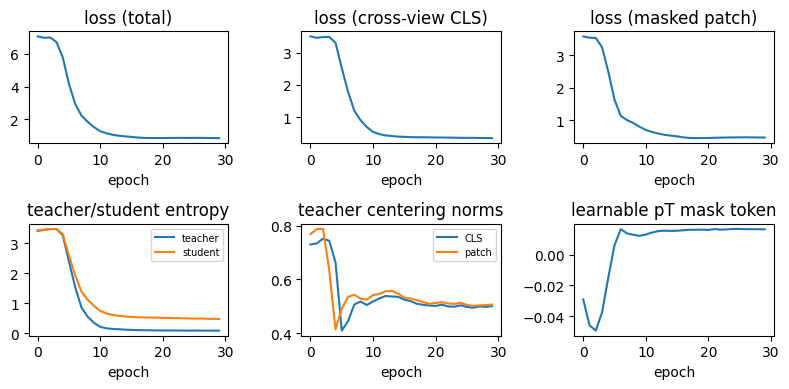

In [8]:
def plot_ibot_training(history):
    fig, ax = plt.subplots(2, 3, figsize=(8, 4), sharex=False)
    ax[0,0].plot(history["loss_total"])
    ax[0,0].set_title("loss (total)")
    ax[0,0].set_xlabel("epoch")

    ax[0,1].plot(history["loss_cls"])
    ax[0,1].set_title("loss (cross-view CLS)")
    ax[0,1].set_xlabel("epoch")

    ax[0,2].plot(history["loss_patch"])
    ax[0,2].set_title("loss (masked patch)")
    ax[0,2].set_xlabel("epoch")

    ax[1,0].plot(history["entropy_teacher"], label="teacher")
    ax[1,0].plot(history["entropy_student"], label="student")
    ax[1,0].set_title("teacher/student entropy")
    ax[1,0].set_xlabel("epoch")
    ax[1,0].legend(fontsize=7)

    ax[1,1].plot(history["center_cls"], label="CLS")
    ax[1,1].plot(history["center_patch"], label="patch")
    ax[1,1].set_title("teacher centering norms")
    ax[1,1].set_xlabel("epoch")
    ax[1,1].legend(fontsize=7)

    ax[1,2].plot(history["mask_token"])
    ax[1,2].set_title("learnable pT mask token")
    ax[1,2].set_xlabel("epoch")
    plt.tight_layout()
    plt.show()

plot_ibot_training(history_ibot_5class)

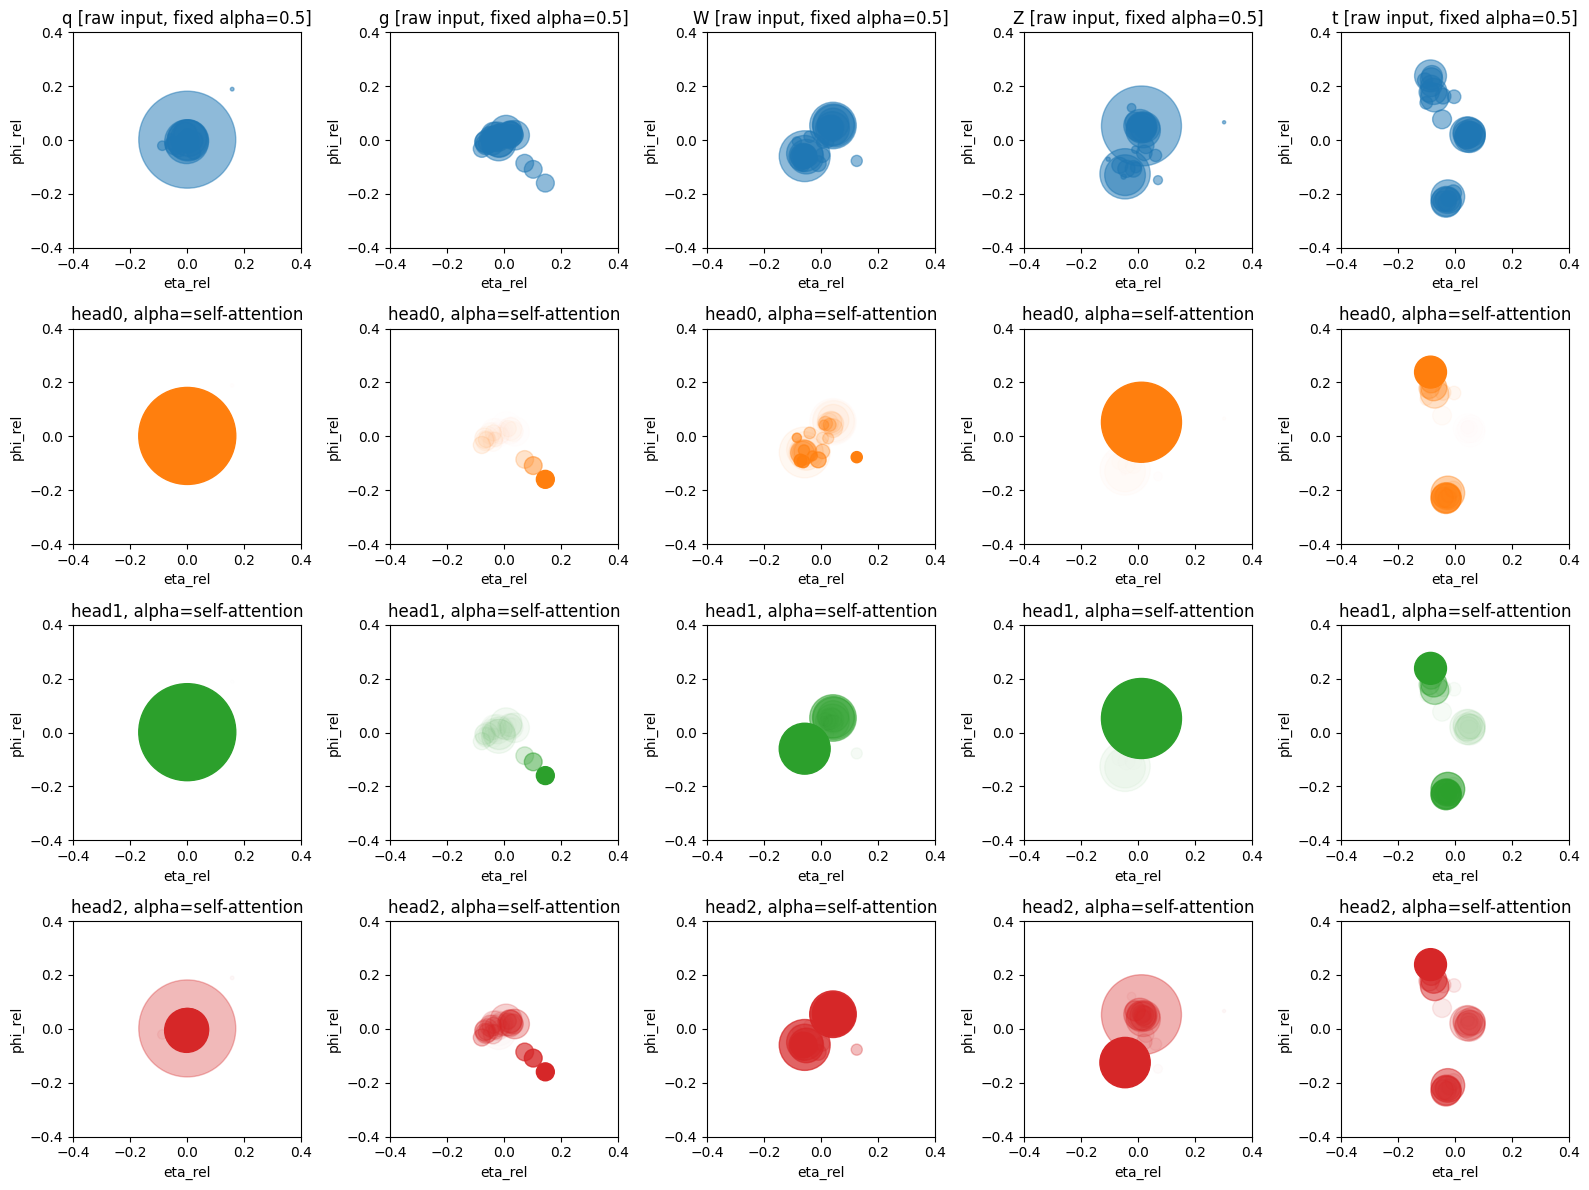

In [9]:
def plot_attention(transformer, n_heads, n_layers):
    last_block = transformer.get_layer(f"block_{n_layers-1}")
    mha_last = last_block.mha
    #heads = getattr(mha_last, "num_heads", getattr(mha_last, "_num_heads"))

    # rebuild model with attention scores as output
    x_in = transformer.input
    x = transformer.get_layer("token_embedding")(x_in)
    x = transformer.get_layer("prepend_cls")(x)
    for i in range(n_layers-1):
        x = transformer.get_layer(f"block_{i}")(x)
    _, attn_scores = mha_last(x, x, return_attention_scores=True)
    model_re = tf.keras.Model(x_in, attn_scores)

    class_names = ['q', 'g', 'W', 'Z', 't']
    rows = 1 + n_heads
    fig, axes = plt.subplots(rows, 5, figsize=(16, 3*rows))

    for col, cname in enumerate(class_names):
        idx = np.where(y_train.argmax(axis=1)==col)[0][0]
        jet = x_train[idx][None, ...].astype("float32") # (1,30,4)
        scores = model_re(jet).numpy()[0] # (n_heads, 31, 31)
        QUERYcls_KEYpatch = scores[:, 0, 1:] # (n_heads, 30)

        eta, phi, pt, valid = jet[0].T
        eta, phi, pt = eta[valid==1], phi[valid==1], pt[valid==1]
        QUERYcls_KEYpatch = QUERYcls_KEYpatch[:, valid==1]

        ax0 = axes[0, col]
        ax0.scatter(eta, phi, color="C0", s=pt*1e4, alpha=0.5)
        ax0.set_title(f"{cname} [raw input, fixed alpha=0.5]")
        ax0.set_xlim(-0.4, 0.4)
        ax0.set_ylim(-0.4, 0.4)

        for h in range(n_heads):
            w = QUERYcls_KEYpatch[h]
            w = (w - w.min())/(w.ptp() + 1e-8) # normalized
            ax = axes[1+h, col]
            ax.scatter(eta, phi, color=f"C{h+1}", s=pt*1e4, alpha=w)
            if col==0: ax.set_ylabel(f"head {h}")
            ax.set_title(f"head{h}, alpha=self-attention")
            ax.set_xlim(-0.4, 0.4)
            ax.set_ylim(-0.4, 0.4)

    for r in range(rows):
        for c in range(5):
            axes[r,c].set_xlabel("eta_rel")
            axes[r,c].set_ylabel("phi_rel")

    plt.tight_layout()
    plt.show()

plot_attention(transformer=student, n_heads=n_heads, n_layers=n_layers)

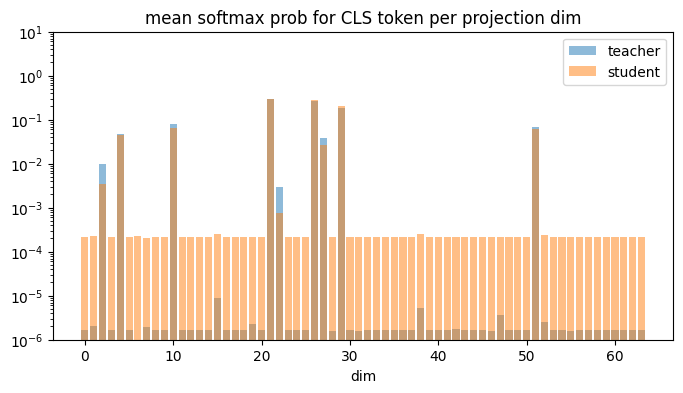

In [10]:
def plot_softmax_prob_cls(n_samples, student, teacher, proj_head_s, proj_head_t, center_cls, temp_t, temp_s):
    x_sample = x_test[:n_samples].astype("float32")
    z_teacher = proj_head_t(teacher(x_sample)[0])
    prob_t = tf.nn.softmax((z_teacher-center_cls)/temp_t, axis=-1)
    mean_prob_t = tf.reduce_mean(prob_t, axis=0).numpy()

    z_student = proj_head_s(student(x_sample)[0])
    prob_s = tf.nn.softmax(z_student/temp_s, axis=-1)
    mean_prob_s = tf.reduce_mean(prob_s, axis=0).numpy()

    plt.figure(figsize=(8,4))
    plt.bar(np.arange(d_proj), mean_prob_t, label="teacher", alpha=0.5)
    plt.bar(np.arange(d_proj), mean_prob_s, label="student", alpha=0.5)
    plt.yscale("log")
    plt.ylim(1e-6, 10)
    plt.legend()
    plt.title("mean softmax prob for CLS token per projection dim")
    plt.xlabel("dim")

plot_softmax_prob_cls(n_samples=5000,
                      student=student, teacher=teacher,
                      proj_head_s=proj_head_s, proj_head_t=proj_head_t,
                      center_cls=center_cls, temp_t=0.04, temp_s=0.1)

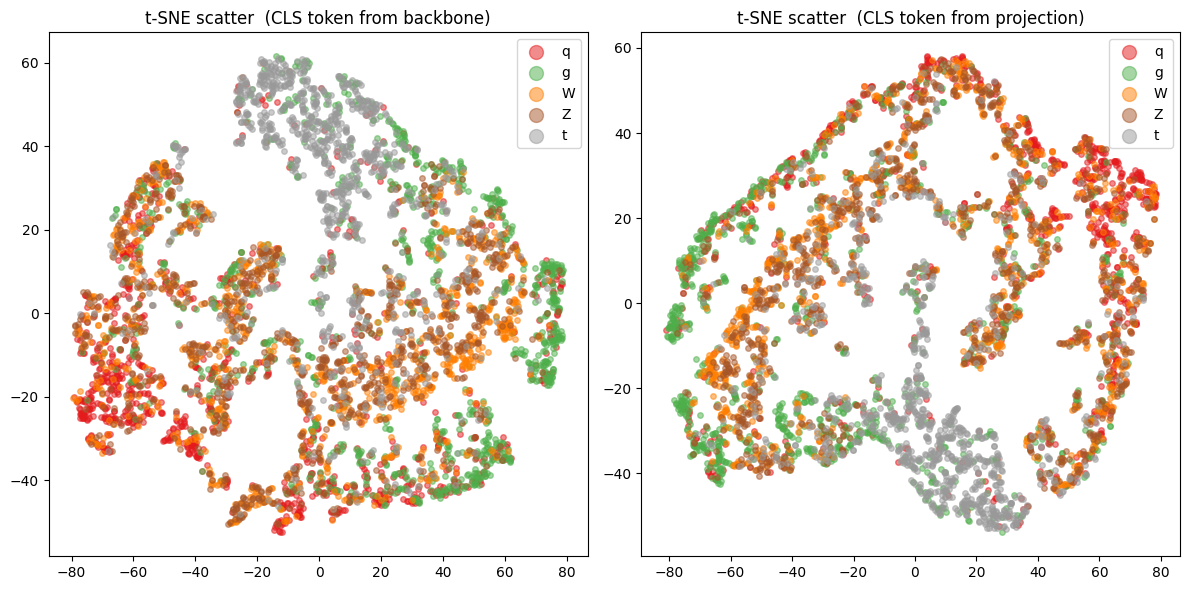

In [ ]:
def plot_tSNE_cls(n_samples, student, proj_head_s):
    x_sample = x_train[:n_samples].astype("float32")
    y_sample = y_train[:n_samples].argmax(1)
    palette = plt.cm.Set1(np.linspace(0,1,5))
    class_names = ['q', 'g', 'W', 'Z', 't']

    z_backbone = student(x_sample)[0].numpy()
    z_projection = proj_head_s(z_backbone).numpy()

    tsne_backbone = TSNE(2, random_state=42).fit_transform(z_backbone)
    tsne_projection = TSNE(2, random_state=42).fit_transform(z_projection)

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    for k,c in enumerate(class_names):
        ax[0].scatter(tsne_backbone[y_sample==k,0], tsne_backbone[y_sample==k,1], s=16, label=c, color=palette[k], alpha=0.5)
    ax[0].set_title("t-SNE scatter (CLS token from backbone)")
    #ax[0].axis("off")
    ax[0].legend(markerscale=2.5)

    for k,c in enumerate(class_names):
        ax[1].scatter(tsne_projection[y_sample==k,0], tsne_projection[y_sample==k,1], s=16, label=c, color=palette[k], alpha=0.5)
    ax[1].set_title("t-SNE scatter (CLS token from projection)")
    #ax[1].axis("off")
    ax[1].legend(markerscale=2.5)
    plt.tight_layout()
    plt.show()

plot_tSNE_cls(n_samples=5000, student=student, proj_head_s=proj_head_s)

In [ ]:
z_cls_train = student.predict(x_train)[0]
z_cls_test = student.predict(x_test)[0]

y_train_idx = y_train.argmax(1)
y_test_idx = y_test.argmax(1)

knn = KNeighborsClassifier(n_neighbors=20).fit(z_cls_train, y_train_idx)
acc_knn = accuracy_score(y_test_idx, knn.predict(z_cls_test))

scaler = StandardScaler().fit(z_cls_train)
Z_cls_train, Z_cls_test = scaler.transform(z_cls_train), scaler.transform(z_cls_test)
logreg = LogisticRegression(max_iter=1000).fit(Z_cls_train, y_train_idx)
acc_linear = accuracy_score(y_test_idx, logreg.predict(Z_cls_test))

print(f"k-NN acc: {acc_knn:.3f}")
print(f"linear acc: {acc_linear:.3f}")

knn_p = knn.predict_proba(z_cls_test)
linear_p = logreg.predict_proba(Z_cls_test)

6250/6250 [==============================] - 60s 10ms/step
k-NN acc: 0.641
linear acc: 0.632


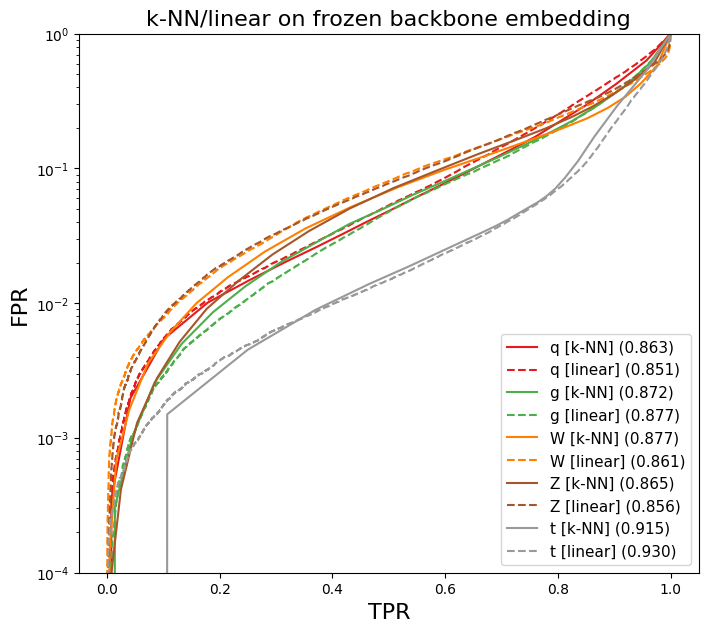

In [ ]:
plt.figure(figsize=(8,7))
colors = plt.cm.Set1(np.linspace(0,1,5))
class_names = ['q','g','W','Z','t']

for k,c in enumerate(class_names):
    fpr_k, tpr_k, _ = roc_curve(y_test[:,k], knn_p[:,k])
    auc_k = auc(fpr_k, tpr_k)
    plt.plot(tpr_k, fpr_k, color=colors[k], label=f"{c} [k-NN] ({auc_k:.3f})", linestyle="-", lw=1.5)

    fpr_l, tpr_l, _ = roc_curve(y_test[:,k], linear_p[:,k])
    auc_l = auc(fpr_l, tpr_l)
    plt.plot(tpr_l, fpr_l, color=colors[k], label=f"{c} [linear] ({auc_l:.3f})", linestyle="--", lw=1.5)

plt.xlabel("TPR", size=16)
plt.ylabel("FPR", size=16)
plt.yscale("log")
plt.ylim(1e-4,1)
plt.title("k-NN/linear on frozen backbone embedding", size=16)
plt.legend(fontsize=11)
plt.show()

## AD (train ibot with q/g only)

In [107]:
d_model=64
n_heads=3
n_layers=3
d_proj=64

student_ad = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)
teacher_ad = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)

proj_head_s_ad = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_student")
proj_head_t_ad = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_teacher")

teacher_ad.set_weights(student_ad.get_weights())
proj_head_t_ad.set_weights(proj_head_s_ad.get_weights())
teacher_ad.trainable = False
proj_head_t_ad.trainable = False

print(student_ad.summary())
print(proj_head_s_ad.summary())

Model: "backbone"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 particles_in (InputLayer)   [(None, 30, 4)]              0         []                            
                                                                                                  
 token_embedding (Dense)     (None, 30, 64)               320       ['particles_in[0][0]']        
                                                                                                  
 prepend_cls (AddClsToken)   (None, 31, 64)               64        ['token_embedding[0][0]']     
                                                                                                  
 block_0 (TransformerBlock)  (None, 31, 64)               49725     ['prepend_cls[0][0]']         
                                                                                           

epoch 1/40 | loss(total)=7.1221; loss(cls)=3.5718; loss(patch)=3.5503; entropy(teacher)=3.279; entropy(student)=3.456; norm(center_cls)=0.73; norm(center_patch)=0.76; mask_token=8.791e-04
epoch 2/40 | loss(total)=6.5685; loss(cls)=3.2028; loss(patch)=3.3657; entropy(teacher)=3.175; entropy(student)=3.187; norm(center_cls)=0.68; norm(center_patch)=0.70; mask_token=5.901e-05
epoch 3/40 | loss(total)=6.6327; loss(cls)=3.2331; loss(patch)=3.3996; entropy(teacher)=3.222; entropy(student)=3.209; norm(center_cls)=0.70; norm(center_patch)=0.71; mask_token=5.783e-04
epoch 4/40 | loss(total)=6.7340; loss(cls)=3.2863; loss(patch)=3.4476; entropy(teacher)=3.279; entropy(student)=3.273; norm(center_cls)=0.69; norm(center_patch)=0.68; mask_token=2.854e-03
epoch 5/40 | loss(total)=6.7846; loss(cls)=3.3170; loss(patch)=3.4676; entropy(teacher)=3.313; entropy(student)=3.315; norm(center_cls)=0.69; norm(center_patch)=0.68; mask_token=7.019e-03
epoch 6/40 | loss(total)=6.8135; loss(cls)=3.3370; loss(patc

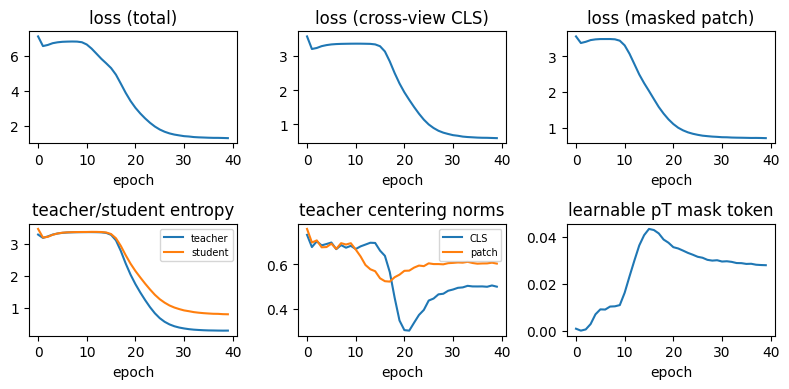

In [108]:
normal_mask_train = (y_train[:,0] + y_train[:,1])==1
anomaly_mask_train = ~normal_mask_train

x_train_normal = x_train[normal_mask_train]
x_train_anomaly = x_train[anomaly_mask_train]

pT_mask_token_ad = tf.Variable(0., trainable=True, name="mask_pt_token")
center_cls_ad = tf.Variable(tf.zeros([d_proj]), trainable=False)
center_patch_ad = tf.Variable(tf.zeros([d_proj]), trainable=False)

history_ibot_2class = train_ibot(x_train=x_train_normal,
                                 epochs=40,
                                 batch_size=256,
                                 optimizer=tf.keras.optimizers.legacy.Adam(2e-4),
                                 ema_tau=0.996,
                                 student=student_ad,
                                 teacher=teacher_ad,
                                 proj_head_s=proj_head_s_ad,
                                 proj_head_t=proj_head_t_ad,
                                 mask_ratio_ibot=0.3,
                                 pT_mask_token=pT_mask_token_ad,
                                 center_cls=center_cls_ad,
                                 center_patch=center_patch_ad,
                                 center_beta=0.9,
                                 temp_t=0.04,
                                 temp_s=0.1)

plot_ibot_training(history_ibot_2class)

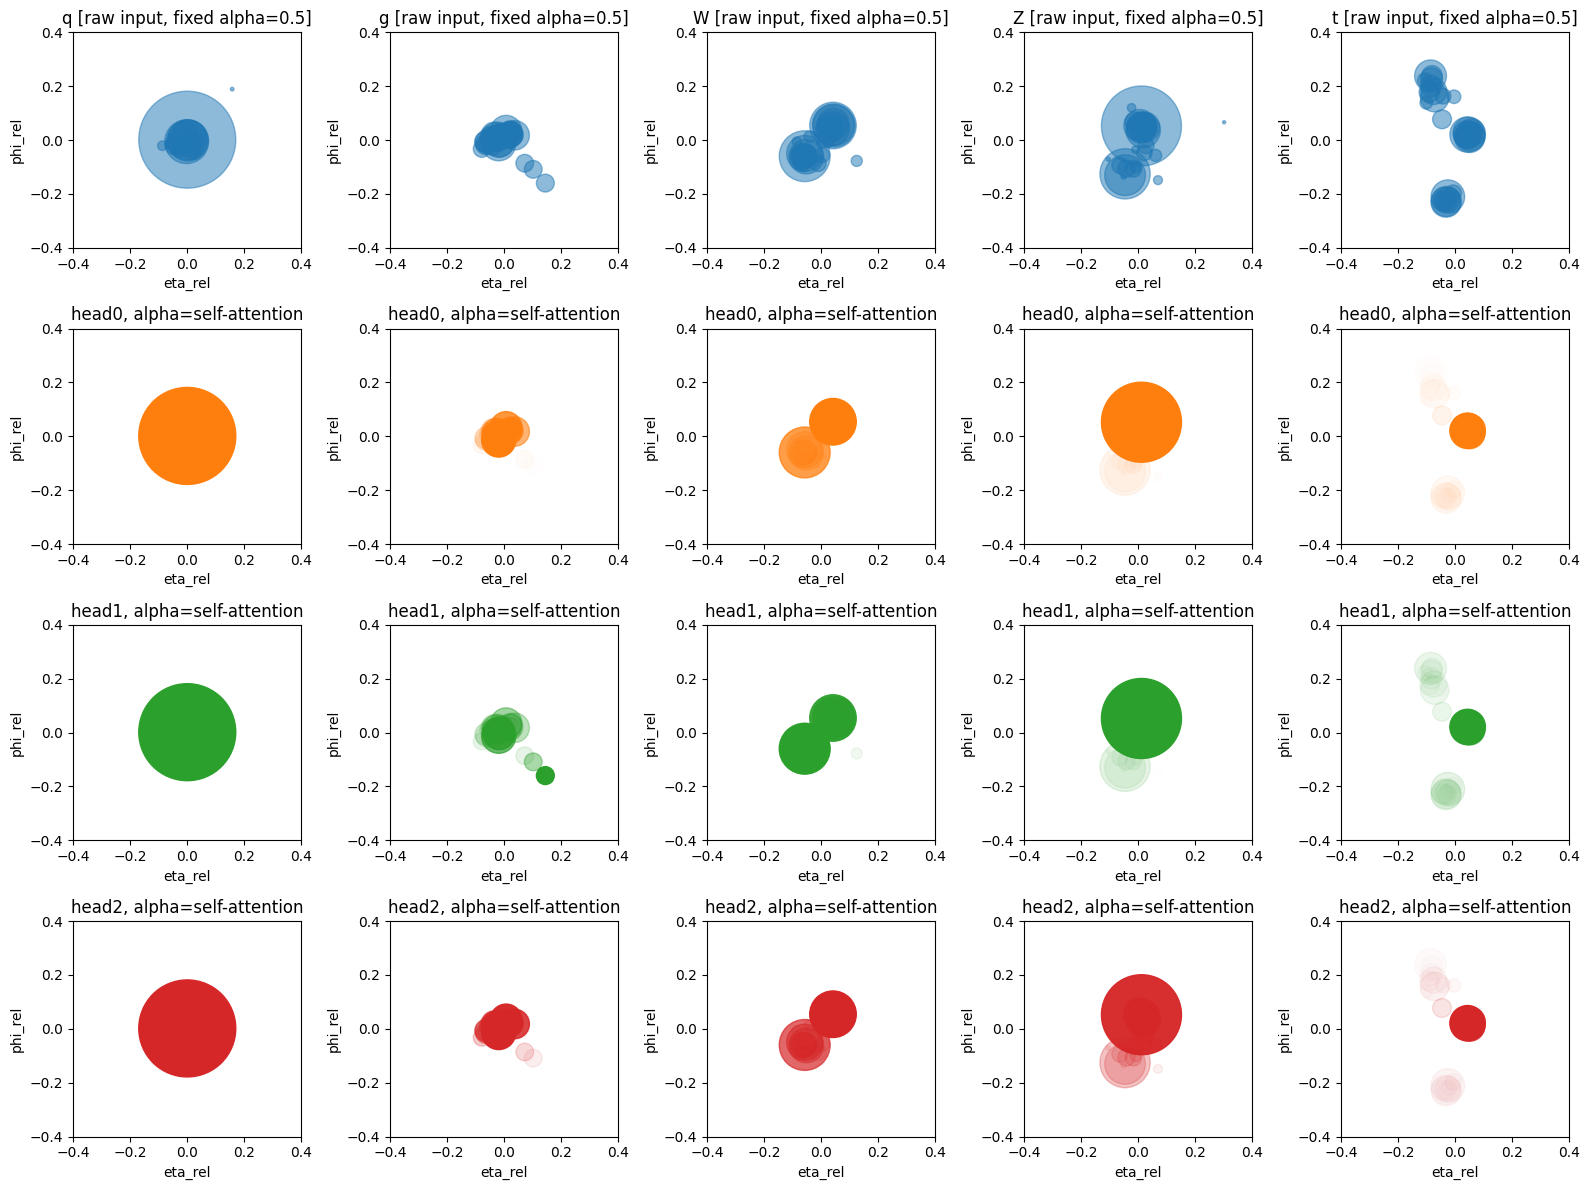

In [110]:
plot_attention(transformer=student_ad, n_heads=n_heads, n_layers=n_layers)

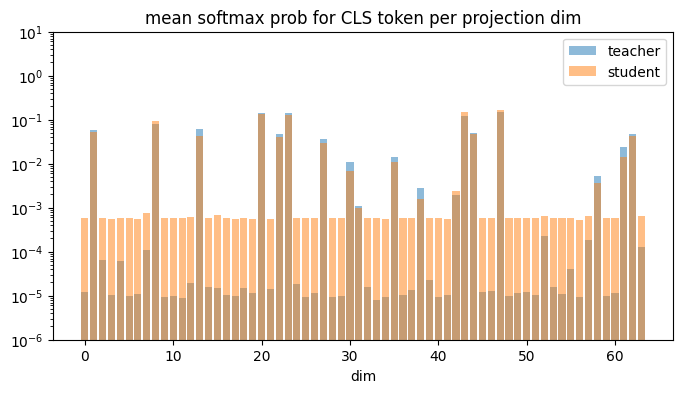

In [111]:
plot_softmax_prob_cls(n_samples=5000,
                      student=student_ad, teacher=teacher_ad,
                      proj_head_s=proj_head_s_ad, proj_head_t=proj_head_t_ad,
                      center_cls=center_cls_ad, temp_t=0.04, temp_s=0.1)

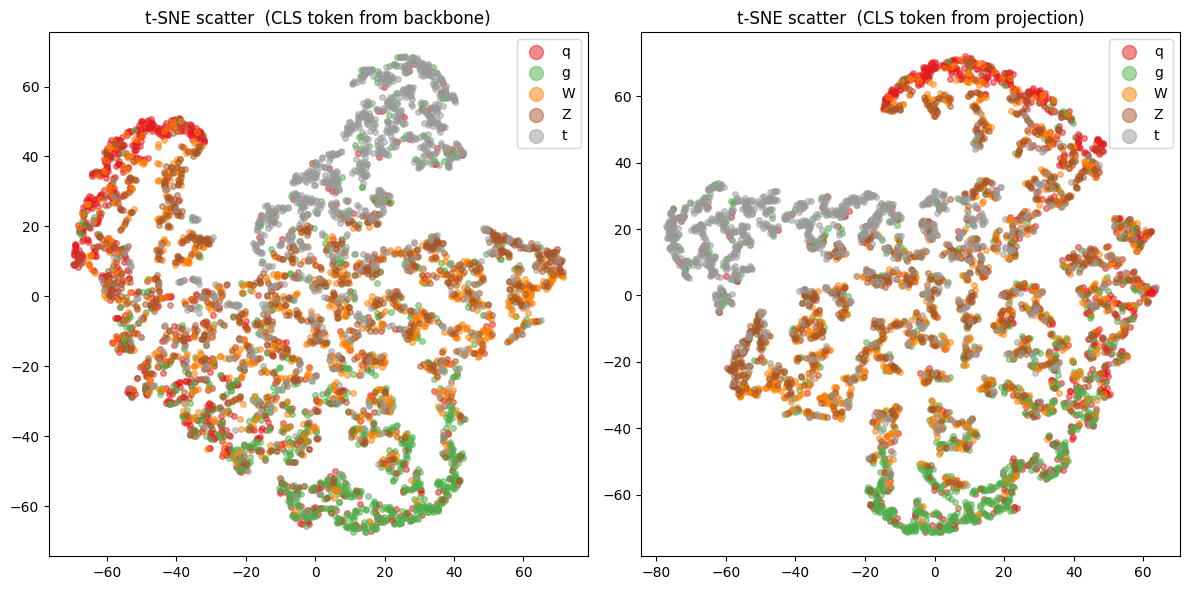

In [112]:
plot_tSNE_cls(n_samples=5000, student=student_ad, proj_head_s=proj_head_s_ad)

In [113]:
z_train_normal = student_ad.predict(x_train_normal)[0] 
knn_ad_bank = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(z_train_normal)

def ad_score_knn(x, student_ad, knn_ad_bank):
    z = student_ad.predict(x)[0] 
    dist, _ = knn_ad_bank.kneighbors(z)
    return dist.mean(axis=1)

normal_mask_test = (y_test[:,0]==1) | (y_test[:,1]==1)
x_test_normal = x_test[normal_mask_test]
score_normal = ad_score_knn(x_test_normal, student_ad, knn_ad_bank)

anomaly_classes = {2:'W', 3:'Z', 4:'t'}
scores_anomaly = {}
for i,(col,name) in enumerate(anomaly_classes.items()):
    anomaly_mask_test = y_test[:,col]==1
    x_test_anomaly = x_test[anomaly_mask_test]
    scores_anomaly[name] = ad_score_knn(x_test_anomaly, student_ad, knn_ad_bank)

1264/1264 [==============================] - 12s 9ms/step


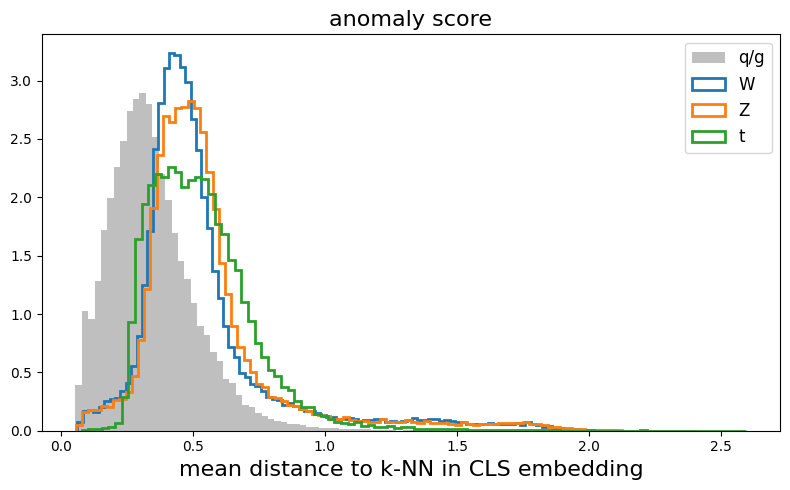

In [121]:
plt.figure(figsize=(8,5))
plt.hist(score_normal, bins=100, density=True, color='grey', alpha=0.5, label='q/g')
for (name, score), i in zip(scores_anomaly.items(), range(len(scores_anomaly))):
    plt.hist(score, bins=100, density=True, histtype='step', linewidth=2, color=f"C{i}", label=f"{name}")

plt.xlabel("mean distance to k-NN in CLS embedding", size=16)
plt.title("anomaly score", size=16)
#plt.xlim(0,2)
#plt.yscale("log")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

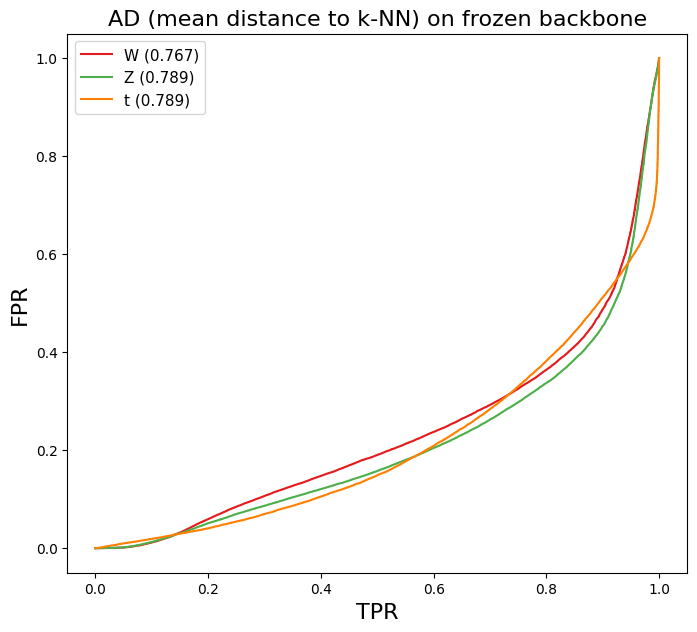

In [124]:
plt.figure(figsize=(8,7))
colors = plt.cm.Set1(np.linspace(0,1,5))

for i,(col,name) in enumerate(anomaly_classes.items()):
    y_true = np.concatenate([np.zeros_like(score_normal), np.ones_like(scores_anomaly[name])])
    scores = np.concatenate([score_normal, scores_anomaly[name]])

    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_ = auc(fpr, tpr)
    plt.plot(tpr, fpr, color=colors[i], label=f"{name} ({auc_:.3f})", linestyle="-", lw=1.5)

plt.xlabel("TPR", size=16)
plt.ylabel("FPR", size=16)
#plt.yscale("log")
#plt.ylim(1e-4,1)
plt.title("AD (mean distance to k-NN) on frozen backbone", size=16)
plt.legend(fontsize=11)
plt.show()